<a href="https://colab.research.google.com/github/JacobDowns/CSCI-491-591/blob/main/lecture2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example: Doing Something Interesting with Numpy




In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# Simulation constants, mostly taken from original code
A_PIPE = 0.6  # virtual pipe cross section
G = 9.81      # gravitational acceleration
L_PIPE = 1    # virtual pipe length
LX = 1        # horizontal distance between grid points
LY = 1        # vertical distance between grid points

In [23]:
from scipy.ndimage import gaussian_filter


def generate_terrain(n, steps=10):
  z = np.zeros((n, n))
  for i in range(steps):
    z_i = np.random.randn(n, n)
    sigma = float(n/(2.*(i+1)))
    z_i = gaussian_filter(z_i, sigma = sigma)
    z += z_i
  z = (z - z.min()) / (z.max() - z.min())
  return z



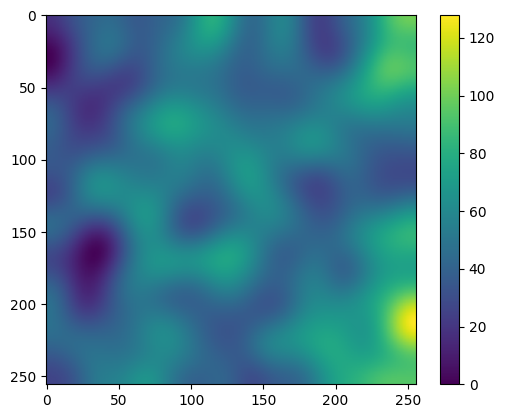

In [27]:
N = 256
z = 128.*generate_terrain(N)
plt.imshow(z)
plt.colorbar()
plt.show()

In [26]:
# Initial water height
h = np.ones((N, N))*1.
# Time step
dt = 0.1

fL = np.zeros((N, N))
fR = np.zeros((N, N))
fT = np.zeros((N, N))
fB = np.zeros((N, N))
u = np.zeros((N, N))
v = np.zeros((N, N))

In [ ]:
def update(z, h, r, fL, fR, fT, fB, u, v):
    h1 = h + dt*r
    H = z + h
    N = H.shape[0]
    # 3.2.1 outflow flux computation
    # ================================================================
    # eqn 3
    # ----------------------------------------------------------------
    # difference in height between tile (j, i) and its neighbors.
    # this drives the initial flux calculations

    dhL = H[1:-1, 1:-1] - H[1:-1, 0:-2]
    dhR = H[1:-1, 1:-1] - H[1:-1, 2:]
    dhT = H[1:-1, 1:-1] - H[0:-2, 1:-1]
    dhB = H[1:-1, 1:-1] - H[2:, 1:-1]

    # eqn 2
    # ----------------------------------------------------------------
    # update flux from tile (j, i) to each neighbor.
    # we don't allow negative flux

    flux_factor = dt* A_PIPE / L_PIPE * G
    fL[1:-1, 1:-1] = np.maximum(flux_factor * dhL[1:-1,1:-1], 0)
    fR[1:-1, 1:-1] = np.maximum(flux_factor * dhR[1:-1,1:-1], 0)
    fT[1:-1, 1:-1] = np.maximum(flux_factor * dhT[1:-1,1:-1], 0)
    fB[1:-1, 1:-1] = np.maximum(flux_factor * dhB[1:-1,1:-1], 0)


    sum_f = fL + fR + fT + fB

    with np.errstate(divide='ignore', invalid='ignore'):
        factor = np.minimum(1.0, (h1[1:-1,1:-1] * LX * LY) / (sum_f * dt))
    factor = np.where(sum_f > 0.0, factor, 1.0)

    fL[1:-1, 1:-1] *= factor
    fR[1:-1, 1:-1] *= factor
    fT[1:-1, 1:-1] *= factor
    fB[1:-1, 1:-1] *= factor

    # Set edge fluxes to 0 to prevent leaking.
    fL[0, :] = 0
    fR[-1, :] = 0
    fT[:, 0] = 0
    fB[:, -1] = 0

    # 3.2.2 water surface and velocity field update
    # ================================================================

    # Flux coming into (j, i)
    sum_f_in = fR[1:-1,0:-2] + fT[2:, 1:-1] + fL[1:-1, 2:] + fB[0:-2, 1:-1]
    # Flux going out of (j, i)
    sum_f_out = fL[1:-1,1:-1] + fR[1:-1,1:-1] + fT[1:-1,1:-1] + fB[1:-1,1:-1]

    # eqn 6: delta volume
    # ----------------------------------------------------------------
    dvol = dt * (sum_f_in - sum_f_out)


    # eqn 7: update water height
    # ----------------------------------------------------------------
    dh = dvol / (LX * LY)
    h2 = h1[1:-1,1:-1] + dh

    # Overwrite h
    h[:,:] = h2[:,:]



    """
    h_mean = h1 + 0.5 * dh


    dwx = fR[1:-1, 0:-2] - fL[1:-1,1:-1] + fR[1:-1,1:-1] - fL[1:-1,2:]
    dwy = fB[0:-2, 1:-1] = fT[1:-1,1:-1] + fB[1:-1,1:-1] - fT[2:,1:-1]
    u[:,:] = 0.
    u[:,:] = 0.

    indexes = h_mean > 0.
    u[indexes] = dwx[indexes] / (LY * h_mean[indexes])
    v[indexes] = dwy[indexes] / (LX * h_mean[indexes])
    """

    return z, h, fL, fR, fB, fT


In [31]:
list(range(1,7))

[1, 2, 3, 4, 5, 6]

In [32]:
np.arange(8)[1:-1]

array([1, 2, 3, 4, 5, 6])